In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cargar el archivo df_train.parquet y df_test.parquet

train_dataset = pd.read_parquet('df_train.parquet') #.head(2000)

X_kaggle  = pd.read_parquet('df_test.parquet')

train_dataset = train_dataset.sample(n=3000, random_state=42)

1. Preprocesamiento de datos
En este paso nos aseguramos de que los datos estén bien escalados antes de entrenar la red neuronal.

In [3]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler


1. Definir funciones de activación
Coloca las definiciones de las funciones de activación (incluyendo sigmoid) al principio del archivo:

In [4]:
import numpy as np

# Función Sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Derivada de la función Sigmoide
def sigmoid_derivative(a):
    return a * (1 - a)

# Función ReLU
def relu(z):
    return np.maximum(0, z)

# Derivada de la función ReLU
def relu_derivative(a):
    return (a > 0).astype(float)


2. Regularización L2
Vamos a añadir una penalización de L2 (regularización) que aplicaremos a los pesos durante el entrenamiento para prevenir el sobreajuste.

In [5]:
def compute_l2_penalty(weights, l2_lambda):
    l2_penalty = 0
    for w in weights:
        l2_penalty += np.sum(np.square(w))
    return (l2_lambda / 2) * l2_penalty


3. Aplicar dropout
Dropout apaga aleatoriamente neuronas durante el entrenamiento para mejorar la robustez del modelo.

In [6]:
def apply_dropout(a, dropout_rate):
    mask = np.random.rand(*a.shape) > dropout_rate
    return a * mask / (1 - dropout_rate)


4. Funciones de activación (optimización con Optuna)
Añadimos la posibilidad de probar diferentes funciones de activación a través de un hiperparámetro.

In [7]:
def get_activation(activation_name):
    if activation_name == "relu":
        return relu, relu_derivative
    elif activation_name == "sigmoid":
        return sigmoid, sigmoid_derivative
    elif activation_name == "tanh":
        return np.tanh, lambda a: 1 - np.tanh(a) ** 2
    else:
        raise ValueError(f"Función de activación desconocida: {activation_name}")


5. Propagación hacia adelante (con batch normalization y dropout)
Incorporamos batch normalization y dropout en la propagación hacia adelante.

In [8]:
def forward_propagation(X, weights, biases, activation_name, dropout_rate, use_batchnorm=False):
    activations = [X]
    z_values = []
    activation_fn, _ = get_activation(activation_name)
    
    for i in range(len(weights) - 1):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        if use_batchnorm:
            z = batch_normalization(z)
        a = activation_fn(z)
        if dropout_rate > 0:
            a = apply_dropout(a, dropout_rate)
        z_values.append(z)
        activations.append(a)
    
    # Capa de salida
    z = np.dot(activations[-1], weights[-1]) + biases[-1]
    a = sigmoid(z)
    z_values.append(z)
    activations.append(a)
    
    return activations, z_values


6. Batch normalization
Normalizamos las activaciones de cada capa, lo que ayuda a estabilizar y acelerar el entrenamiento.

In [9]:
def batch_normalization(a, epsilon=1e-5):
    mean = np.mean(a, axis=0)
    variance = np.var(a, axis=0)
    return (a - mean) / np.sqrt(variance + epsilon)


7. Retropropagación con regularización L2
Calculamos los gradientes y aplicamos la regularización L2.

In [10]:
def back_propagation(y, activations, z_values, weights, l2_lambda, activation_name):
    m = y.shape[0]
    deltas = []
    grads_w = []
    grads_b = []
    _, activation_deriv = get_activation(activation_name)
    
    # Cálculo del error en la capa de salida
    delta = activations[-1] - y.reshape(-1, 1)
    deltas.append(delta)
    
    # Gradientes de la capa de salida
    dw = np.dot(activations[-2].T, delta) / m + l2_lambda * weights[-1] / m
    db = np.sum(delta, axis=0, keepdims=True) / m
    grads_w.insert(0, dw)
    grads_b.insert(0, db)
    
    # Retropropagación a través de las capas ocultas
    for i in reversed(range(len(weights) - 1)):
        delta = np.dot(delta, weights[i + 1].T) * activation_deriv(activations[i + 1])
        dw = np.dot(activations[i].T, delta) / m + l2_lambda * weights[i] / m
        db = np.sum(delta, axis=0, keepdims=True) / m
        grads_w.insert(0, dw)
        grads_b.insert(0, db)
    
    return grads_w, grads_b


8. Función de entrenamiento (con early stopping y optimización Adam)
Aquí combinamos la optimización Adam, early stopping, y regularización L2.

In [11]:
y_pred = pd.DataFrame(columns=[('Target')])
y_pred.index.name = 'ID'

In [12]:
def train_network(X_train, y_train, X_test, y_test, X_kaggle, params):
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    hidden_layers = params['hidden_layers']
    activation_name = params['activation']
    dropout_rate = params['dropout_rate']
    l2_lambda = params['l2_lambda']
    use_batchnorm = params['batchnorm']
    early_stopping_patience = params['early_stopping_patience']
    
    # Inicialización de pesos y sesgos
    weights = []
    biases = []
    layer_dims = [X_train.shape[1]] + hidden_layers + [1]
    
    for i in range(len(layer_dims) - 1):
        w = np.random.randn(layer_dims[i], layer_dims[i + 1]) * 0.01
        b = np.zeros((1, layer_dims[i + 1]))
        weights.append(w)
        biases.append(b)
    
    best_valid_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Propagación hacia adelante
        activations, z_values = forward_propagation(X_train, weights, biases, activation_name, dropout_rate, use_batchnorm)
        
        # Retropropagación
        grads_w, grads_b = back_propagation(y_train, activations, z_values, weights, l2_lambda, activation_name)
        
        # Actualización de pesos y sesgos (Optimización Adam)
        for i in range(len(weights)):
            weights[i] -= learning_rate * grads_w[i]
            biases[i] -= learning_rate * grads_b[i]
        
        if epoch % 100 == 0:
            # Cálculo de la pérdida en validación
            activations_valid, _ = forward_propagation(X_test, weights, biases, activation_name, 0, use_batchnorm)
            y_pred_valid = activations_valid[-1]
            valid_loss = np.mean((y_test.reshape(-1, 1) - y_pred_valid) ** 2) + compute_l2_penalty(weights, l2_lambda)
            
            # Early stopping
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Deteniendo el entrenamiento en la época {epoch} debido a early stopping.")
                    break

    # Calcular el accuracy en el conjunto de prueba
    activations_test, _ = forward_propagation(X_test, weights, biases, activation_name, 0, use_batchnorm)
    y_pred_test = activations_test[-1]
    y_pred_test_class = (y_pred_test > 0.5).astype(int)
    accuracy = np.mean(y_pred_test_class == y_test)
    
    # Predicción con X_kaggle
    #activations_kaggle, _ = forward_propagation(X_kaggle, weights, biases, activation_name, 0, use_batchnorm)
    #y_pred_kaggle = activations_kaggle[-1]  # Predicciones con el conjunto X_kaggle
    #y_pred_kaggle_class = (y_pred_kaggle > 0.5).astype(int)  # Clasificación binaria

    # Retornar el accuracy en el conjunto de test y las predicciones para X_kaggle
    return accuracy, y_pred_test_class #, y_pred_kaggle_class




9. Optimización de hiperparámetros con Optuna
Incorporamos la optimización de la función de activación, regularización L2, dropout, y uso de batch normalization.

In [13]:
def objective(trial):
    global y_pred
    epochs                  = trial.suggest_categorical('epochs', [1000]) #, 2000, 5000, 10000])
    learning_rate           = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    num_layers              = trial.suggest_int('num_layers', 1, 2) #4)
    activation_name         = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])
    dropout_rate            = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    l2_lambda               = trial.suggest_loguniform('l2_lambda', 1e-5, 1e-1)
    use_batchnorm           = trial.suggest_categorical('batchnorm', [True, False])
    early_stopping_patience = trial.suggest_int('early_stopping_patience', 10, 100)
    
    hidden_layers = []
    for i in range(num_layers):
        n_neurons = trial.suggest_int(f'n_units_l{i}', 16, 128)
        hidden_layers.append(n_neurons)
    
    params = {
        'epochs': epochs,
        'learning_rate': learning_rate,
        'hidden_layers': hidden_layers,
        'activation': activation_name,
        'dropout_rate': dropout_rate,
        'l2_lambda': l2_lambda,
        'batchnorm': use_batchnorm,
        'early_stopping_patience': early_stopping_patience
    }
    
    global X_train, y_train, X_test, y_test, X_kaggle
    
    y_train = y_train.values.reshape(-1, 1) if isinstance(y_train, pd.Series) else y_train.reshape(-1, 1)
    y_test  = y_test.values.reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test.reshape(-1, 1)

    accuracy, y_pred = train_network(X_train, y_train, X_test, y_test, X_kaggle, params)
    return accuracy

#   valid_loss = train_network(X_train, y_train, X_test, y_test, params)
#   return valid_loss


10. Ejecutar la optimización
Finalmente, ejecutamos la optimización utilizando Optuna:

In [14]:
# Dividir los datos en entrenamiento y validación
#X_train, X_test, y_train,y_test = train_test_split(X_trained, y_train, test_size=0.2, random_state=42)


In [15]:
# Importar librerías necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Separar las variables predictoras y la variable objetivo
X = train_dataset.drop('Target', axis=1)  # Elimina la columna objetivo 'Target'
y = train_dataset['Target']  # Columna objetivo

# Identificar variables categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns.tolist()  # Variables categóricas
num_features = X.select_dtypes(exclude=['object']).columns.tolist()  # Variables numéricas

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Dividir los datos en entrenamiento y validación
#X_train, X_test, y_train,y_test = train_test_split(X_trained, y_train, test_size=0.2, random_state=42)

# Crear un transformador para las variables numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),  # Imputación en numéricas
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)  # OneHotEncoding en categóricas
    ])

In [16]:
from sklearn.decomposition import PCA

In [17]:
X_train = preprocessor.fit_transform(X_train)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Calcular el PCA con todos los componentes
pca = PCA()
pca.fit(X_train)

X_test  = preprocessor.transform(X_test)
X_test  = scaler.fit_transform(X_test)

# Escalado de los datos
X_train, X_test, scaler = preprocess_data(X_train, X_test)


Número de componentes que explican al menos el 80% de la varianza: 26


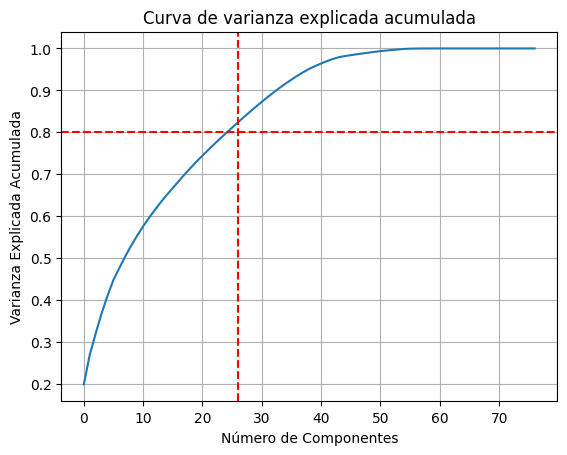

In [18]:

# Calcular la varianza explicada acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Encontrar el número de componentes que explican al menos el 80% de la varianza
n_componentes_80 = np.argmax(varianza_acumulada >= 0.80) + 1  # +1 porque los índices en Python empiezan en 0

print(f"Número de componentes que explican al menos el 80% de la varianza: {n_componentes_80}")

# Graficar la varianza explicada acumulada para ver cómo se comporta
plt.plot(varianza_acumulada)
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Curva de varianza explicada acumulada')
plt.axhline(y=0.80, color='r', linestyle='--')  # Línea en el 80% de la varianza
plt.axvline(x=n_componentes_80, color='r', linestyle='--')  # Línea en el número de componentes seleccionados
plt.grid(True)
plt.show()

In [19]:
# Dejar en X_train solo los componentes que explican al menos el 80% de la varianza
X_train = pca.transform(X_train)[:, :n_componentes_80]
X_test = pca.transform(X_test)[:, :n_componentes_80]
X_kaggle = pca.transform(X_kaggle)[:, :n_componentes_80]

print(f"Dimensiones de X_train_reduced: {X_train.shape}")
print(f"Dimensiones de X_test_reduced: {X_test.shape}")

ValueError: could not convert string to float: 'UL'

In [21]:
import optuna

# Crear el estudio de Optuna
study = optuna.create_study(direction='maximize')

# Ejecutar la optimización con el número de ensayos (trials) que prefieras
study.optimize(objective, n_trials=50)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(study.best_params)

# Ejecutar la función objective con los mejores hiperparámetros encontrados
accuracy = objective(study.best_trial)
print(f"Accuracy con los mejores hiperparámetros: {accuracy}")


[I 2024-10-06 22:32:34,290] A new study created in memory with name: no-name-ece5fbbe-7f23-46ce-9975-409b4d504966
[W 2024-10-06 22:36:38,900] Trial 0 failed with parameters: {'epochs': 1000, 'learning_rate': 0.02957508227265891, 'num_layers': 1, 'activation': 'relu', 'dropout_rate': 0.3337242038475005, 'l2_lambda': 0.0044617394628623285, 'batchnorm': False, 'early_stopping_patience': 35, 'n_units_l0': 94} because of the following error: ValueError('shapes (10069,45) and (26,94) not aligned: 45 (dim 1) != 26 (dim 0)').
Traceback (most recent call last):
  File "C:\Users\apont\AppData\Roaming\Python\Python311\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\apont\AppData\Local\Temp\ipykernel_6480\740093461.py", line 33, in objective
    accuracy, y_pred = train_network(X_train, y_train, X_test, y_test, X_kaggle, params)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ValueError: shapes (10069,45) and (26,94) not aligned: 45 (dim 1) != 26 (dim 0)

In [30]:
def kaggle_submit(test_data, predicciones, competition_name, message="Automated Submission"):
    # Generar archivo de submission
    submission = pd.DataFrame({
        'ID': test_data,
        'Target': predicciones
    })
    submission_file = 'submission.csv'
    submission.to_csv(submission_file, index=False)
    
    # Subir el archivo a Kaggle
    !kaggle competitions submit -c {competition_name} -f {submission_file} -m "{message}"
    
    # Mostrar las submissions recientes
    !kaggle competitions submissions -c {competition_name}


In [ ]:
'''# Guardar el archivo de submission
submission_file = 'submission.csv'

# Guardar el DataFrame 'y_pred' en un archivo CSV
y_pred.to_csv(submission_file, index=True)'''

In [31]:
y_pred.index.name = 'ID'
y_pred            = pd.DataFrame(y_pred, columns=['Target'])

In [ ]:
# Llamar la función
kaggle_submit(y_pred.index, y_pred['Target'], 'fa-ii-2024-ii-flujos-de-modelos-tradicionales')


In [41]:
# Guardar el DataFrame 'y_pred' en un archivo CSV
y_pred.to_csv('submission.csv', index=True)